In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Files already downloaded and verified
Epoch [1/15], Batch [100/1563], Loss: 0.2142
Epoch [1/15], Batch [200/1563], Loss: 0.1971
Epoch [1/15], Batch [300/1563], Loss: 0.1957
Epoch [1/15], Batch [400/1563], Loss: 0.1946
Epoch [1/15], Batch [500/1563], Loss: 0.1953
Epoch [1/15], Batch [600/1563], Loss: 0.1914
Epoch [1/15], Batch [700/1563], Loss: 0.1812
Epoch [1/15], Batch [800/1563], Loss: 0.1724
Epoch [1/15], Batch [900/1563], Loss: 0.1640
Epoch [1/15], Batch [1000/1563], Loss: 0.1558
Epoch [1/15], Batch [1100/1563], Loss: 0.1383
Epoch [1/15], Batch [1200/1563], Loss: 0.1314
Epoch [1/15], Batch [1300/1563], Loss: 0.1268
Epoch [1/15], Batch [1400/1563], Loss: 0.1224
Epoch [1/15], Batch [1500/1563], Loss: 0.1199
Epoch [2/15], Batch [100/1563], Loss: 0.1174
Epoch [2/15], Batch [200/1563], Loss: 0.1172
Epoch [2/15], Batch [300/1563], Loss: 0.1130
Epoch [2/15], Batch [400/1563], Loss: 0.1139
Epoch [2/15], Batch [500/1563], Loss: 0.1120
Epoch [2/15], Batch [600/1563], Loss: 0.1106
Epoch [2/15

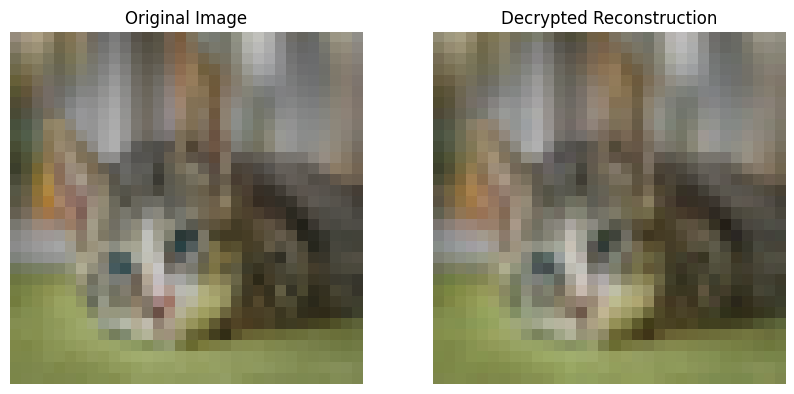

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import numpy as np

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ViTEncoder(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256, depth=6, num_heads=4, mlp_ratio=2.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.n_patches
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, embed_dim * mlp_ratio, batch_first=True)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return x

class ViTDecoder(nn.Module):
    def __init__(self, embed_dim=256, depth=6, num_heads=4, mlp_ratio=2., img_size=32, patch_size=4):
        super().__init__()
        self.blocks = nn.ModuleList([
            nn.TransformerDecoderLayer(embed_dim, num_heads, embed_dim * mlp_ratio, batch_first=True)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, patch_size**2 * 3)
        self.patch_size = patch_size
        self.img_size = img_size

    def forward(self, x, memory):
        for block in self.blocks:
            x = block(x, memory)
        x = self.norm(x)
        x = self.head(x)
        x = x.reshape(-1, 3, self.img_size, self.img_size)
        return x

class ViTAutoencoder(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256, encoder_depth=6, decoder_depth=6,
                 encoder_heads=4, decoder_heads=4, mlp_ratio=2.):
        super().__init__()
        self.encoder = ViTEncoder(img_size, patch_size, in_chans, embed_dim, encoder_depth, encoder_heads, mlp_ratio)
        self.decoder = ViTDecoder(embed_dim, decoder_depth, decoder_heads, mlp_ratio, img_size, patch_size)

    def forward(self, imgs):
        latent = self.encoder(imgs)
        recon = self.decoder(latent, latent)  # Using the same latent as memory for simplicity
        return recon

def float_to_int(float_tensor, scale=255):
    """Transform float tensor [0, 1] to int tensor [0, 255]."""
    return (float_tensor * scale).round().long()

def int_to_float(int_tensor, scale=255):
    """Retrieve float tensor [0, 1] from int tensor [0, 255]."""
    return int_tensor.float() / scale

def xor_encrypt_decrypt(tensor, key):
    """ XOR encryption/decryption on the tensor. """
    device = tensor.device
    # Ensure tensor and key are on the CPU for numpy operations
    tensor = tensor.cpu()
    key = key.cpu()

    # Convert tensor and key to the range [0, 255] and to integer type
    tensor_int = float_to_int(tensor)
    key_int = float_to_int(key)
    
    # Ensure key has the same shape as tensor
    if key_int.shape != tensor_int.shape:
        raise ValueError("Key and tensor must have the same shape.")
    
    # Perform XOR operation
    encrypted_decrypted_tensor = tensor_int ^ key_int
    
    # Convert back to float tensor in range [0, 1]
    encrypted_decrypted_tensor = int_to_float(encrypted_decrypted_tensor)
    
    # Move the result back to the original device
    return encrypted_decrypted_tensor.to(device)

def retrieve_original_tensor(encrypted_tensor):
    """ Convert the encrypted tensor back to the original float tensor. """
    # This function is now just a pass-through, as the conversion is handled in xor_encrypt_decrypt
    return encrypted_tensor

def visualize_reconstruction(model, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Load and preprocess the custom image
    response = requests.get(image_path)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    image_tensor = transform(img).unsqueeze(0).to(device)

    # Encode the image
    with torch.no_grad():
        encoded = model.encoder(image_tensor)

    # Generate XOR key with dimensions matching the encoded tensor
    xor_key = torch.rand_like(encoded)
    
    # Encrypt the encoded image
    encrypted_encoded = xor_encrypt_decrypt(encoded, xor_key)
    
    # Decrypt the encrypted image
    decrypted_encoded = xor_encrypt_decrypt(encrypted_encoded, xor_key)

    # Retrieve the original tensor from decrypted tensor
    retrieved_tensor = retrieve_original_tensor(decrypted_encoded).to(device)
    
    # Decode the retrieved tensor
    with torch.no_grad():
        decoded = model.decoder(retrieved_tensor, retrieved_tensor)  # Use the same tensor as memory for simplicity

    # Convert tensors to images
    original_img = transforms.ToPILImage()(image_tensor.squeeze(0).cpu() * 0.5 + 0.5)
    decrypted_img = transforms.ToPILImage()(decoded.squeeze(0).cpu() * 0.5 + 0.5)

    # Display the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original_img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(decrypted_img)
    ax2.set_title('Decrypted Reconstruction')
    ax2.axis('off')
    plt.show()

# Set up the model and training parameters
img_size = 32
patch_size = 4
embed_dim = 256
encoder_depth = 6
decoder_depth = 6
encoder_heads = 4
decoder_heads = 4
mlp_ratio = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTAutoencoder(img_size, patch_size, 3, embed_dim, encoder_depth, decoder_depth, encoder_heads, decoder_heads, mlp_ratio).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Prepare CIFAR-10 dataset with a smaller batch size
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Training loop with mixed precision
scaler = GradScaler()

def train(model, dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, _ = data
            inputs = inputs.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0

# Train the model
train(model, trainloader, epochs=15)

# Test the model with a custom image URL
custom_image_url = 'https://cdn.pixabay.com/photo/2024/02/28/07/42/european-shorthair-8601492_640.jpg'
visualize_reconstruction(model, custom_image_url)